In [1]:
# credit to https://compneuro.neuromatch.io/tutorials/W2D4_DynamicNetworks/student/W2D4_Tutorial2.html
# and       https://compneuro.neuromatch.io/tutorials/W2D4_DynamicNetworks/student/W2D4_Tutorial3.html

import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt       # root-finding algorithm
from scipy.stats import truncnorm

# Figure Settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
   
# Helper Functions 

def default_pars(**kwargs):
    pars = {}

    # Nociceptive excitatory interneuron parameters
    pars['alpha_E'] = 5.2    # alpha
    pars['beta_E'] = 29.2    # beta
    pars['tau_E'] = 0.01     # tau
    pars['max_E'] = 50       # maximal activity (50 in crodelle2018, 60 in crodelle2021)

    # Nociceptive projection neuron parameters
    pars['alpha_P'] = 11.5    # alpha
    pars['beta_P'] = 28.2     # beta
    pars['tau_P'] = 0.001     # tau
    pars['max_P'] = 50        # maximal activity
    
    # Inhibitory interneuron parameters
    pars['alpha_I'] = 9.5*3.5     # alpha
    pars['beta_I'] = 28.0*3.5     # beta
    pars['tau_I'] = 0.02     # tau
    pars['max_I'] = 80       # maximal activity
    
    # NMDA parameters
    pars['alpha_M'] = 10.0     # alpha
    pars['beta_M'] = 38.0      # beta
    pars['tau_M'] = 1.0        # tau
    pars['max_M'] = 2.0        # maximal M
    pars['NMDA_on'] = True     # set false to inactivate NMDA
                
    
    # Connection strength
    pars['w_ext_innoc_P'] = 0.2    # peripheral innocuous to projection neurons
    pars['w_ext_innoc_I'] = 0.8    # peripheral innocuous to inhibitory interneurons
    pars['w_ext_innoc_E'] = 0.2    # peripheral innocuous to excitatory interneurons
    pars['w_ext_noci_E'] = 1.2     # peripheral nociceptive to excitatory interneurons
    pars['w_ext_noci_P'] = 0.7     # peripheral nociceptive to projection neurons
    
    pars['w_E_P'] = 0.4     # excitatory interneurons to projection neurons
    pars['w_I_P'] = 1.      # inhibitory interneurons to projection neurons
    pars['w_I_E'] = 1.8     # inhibitory interneurons to excitatory interneurons
    pars['w_E_E'] = 0.2     # recurrent excitatory interneurons

    
    
    # simulation parameters
    pars['T'] = 50.          # Total duration of simulation [ms]
    pars['dt'] = .025        # Simulation time step [ms]
    
    pars['r_E_init'] = 0.    # intitial activity of excitatory iterneurons
    pars['r_I_init'] = 0.    # intitial activity of inhibitory iterneurons
    pars['r_P_init'] = 0.    # intitial activity of projection neurons
    pars['g_NMDA_init'] = 0.  # intitial NMDA level
    
    pars['r_ext_noci'] = 0.  #activity of peripheral nociceptive afferents
    pars['r_ext_innoc'] = 0. #activity of peripheral innocuous afferents
    
    # External parameters if any
    for k in kwargs:
        pars[k] = kwargs[k]

    # Vector of discretized time points [ms]
    pars['range_t'] = np.arange(0, pars['T'], pars['dt'])

    return pars

### Afferent input is sampled from a normal distribution at each time point
def GenerateNormalInputs(frequencies, stds, durations, dt):

    instantaneous_freq = []
    for i, freq in enumerate(frequencies):
        nTimeBins = int(np.around(durations[i]/dt, decimals=0))
        std = stds[i]
        X = GetTruncatedNormal(freq, std, low=0, upp=500)
        spikes = X.rvs(nTimeBins)
        instantaneous_freq = np.concatenate((instantaneous_freq, spikes))
    
    return instantaneous_freq

### Normal distribution truncated at low and upp
def GetTruncatedNormal(mean=0, sd=1, low=0, upp=500):

    X = truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
    return X

### Activation function
def F(x, alpha, beta, max_freq):

    f = max_freq*0.5*(1 + np.tanh((x-beta)/alpha))

    return f


### Excitatory interneurons
def dEdt(r_E, r_I, r_ext_noci, r_ext_innoc,
         w_ext_noci_E, w_ext_innoc_E, w_I_E, w_E_E,
         alpha_E, beta_E, max_E, tau_E):
    
    dr_Edt = (-r_E + F(w_ext_noci_E*r_ext_noci + w_ext_innoc_E*r_ext_innoc + w_E_E*r_E - w_I_E*r_I, alpha_E, beta_E, max_E)) / tau_E

    return dr_Edt

### Inhibitory interneurons
def dIdt(r_I, r_ext_innoc,
         w_ext_innoc_I,
         alpha_I, beta_I, max_I, tau_I):
    
    dr_Idt = (-r_I + F(w_ext_innoc_I*r_ext_innoc, alpha_I, beta_I, max_I)) / tau_I

    return dr_Idt

### Projection neurons
def dPdt(r_P, r_E, r_I, r_ext_innoc, r_ext_noci,
         w_E_P, w_I_P, w_ext_innoc_P, w_ext_noci_P, gNMDA,
         alpha_P, beta_P, max_P, tau_P):
    
    dr_Pdt = (-r_P + F(w_ext_innoc_P*r_ext_innoc + (w_ext_noci_P + gNMDA)*r_ext_noci + w_E_P*r_E - w_I_P*r_I, 
                       alpha_P, beta_P, max_P)) / tau_P
    

    return dr_Pdt

## NMDA
def dgNMDAdt(r_P, g_NMDA,
             alpha_M, beta_M, max_M, tau_M):
    
    M_inf = F(r_P, alpha_M, beta_M, max_M)
    dg_NMDAdt = (max_M*M_inf - g_NMDA) / tau_M

    return dg_NMDAdt

### Wilson-Cowan simulation
def simulate_wc_non_neg(alpha_E, beta_E, max_E, tau_E,
                        alpha_I, beta_I, max_I, tau_I,
                        alpha_P, beta_P, max_P, tau_P,
                        alpha_M, beta_M, max_M, tau_M,
                        w_E_P, w_I_P, w_I_E, w_E_E,
                        w_ext_noci_E, w_ext_noci_P,
                        w_ext_innoc_I, w_ext_innoc_P, w_ext_innoc_E,
                        r_ext_innoc, r_ext_noci,
                        r_E_init, r_I_init, r_P_init, g_NMDA_init, NMDA_on,
                        dt, range_t, **other_pars):

    # Initialize activity arrays
    Lt = range_t.size
    r_E = np.append(r_E_init, np.zeros(Lt - 1))
    r_P = np.append(r_P_init, np.zeros(Lt - 1))
    r_I = np.append(r_I_init, np.zeros(Lt - 1))
    g_NMDA = np.append(g_NMDA_init, np.zeros(Lt - 1))
    
    if isinstance(r_ext_innoc, (float, int)):
        r_ext_innoc = r_ext_innoc * np.ones(Lt)
    elif len(r_ext_innoc) != Lt:
        raise Exception("Invalid size of r_ext_innoc")
           
    if isinstance(r_ext_noci, (float, int)):
        r_ext_noci = r_ext_noci * np.ones(Lt)
    elif len(r_ext_noci) != Lt:
        raise Exception("Invalid size of r_ext_noci")

    # Simulate the Wilson-Cowan equations
    for k in range(Lt - 1):
        
        # Calculate the derivative of the excitatory interneurons
        dr_E = dt * dEdt(r_E[k], r_I[k], r_ext_noci[k], r_ext_innoc[k],
                         w_ext_noci_E, w_ext_innoc_E, w_I_E, w_E_E,
                         alpha_E, beta_E, max_E, tau_E)

        # Calculate the derivative of the projection neurons
        dr_P = dt * dPdt(r_P[k], r_E[k], r_I[k], r_ext_innoc[k], r_ext_noci[k],
                         w_E_P, w_I_P, w_ext_innoc_P, w_ext_noci_P, g_NMDA[k],
                         alpha_P, beta_P, max_P, tau_P)
        
        # Calculate the derivative of the inhib population
        dr_I = dt * dIdt(r_I[k], r_ext_innoc[k],
                         w_ext_innoc_I,
                         alpha_I, beta_I, max_I, tau_I)
        
        if NMDA_on:
            dg_NMDA = dt * dgNMDAdt(r_P[k], g_NMDA[k], alpha_M, beta_M, max_M, tau_M)
        else:
            dg_NMDA = 0
        
        # Update using Euler's method
        r_E[k + 1] = max(r_E[k] + dr_E, 0)
        r_P[k + 1] = max(r_P[k] + dr_P, 0)
        r_I[k + 1] = max(r_I[k] + dr_I, 0)
        g_NMDA[k + 1] = max(g_NMDA[k] + dg_NMDA, 0)

    return r_E, r_P, r_I


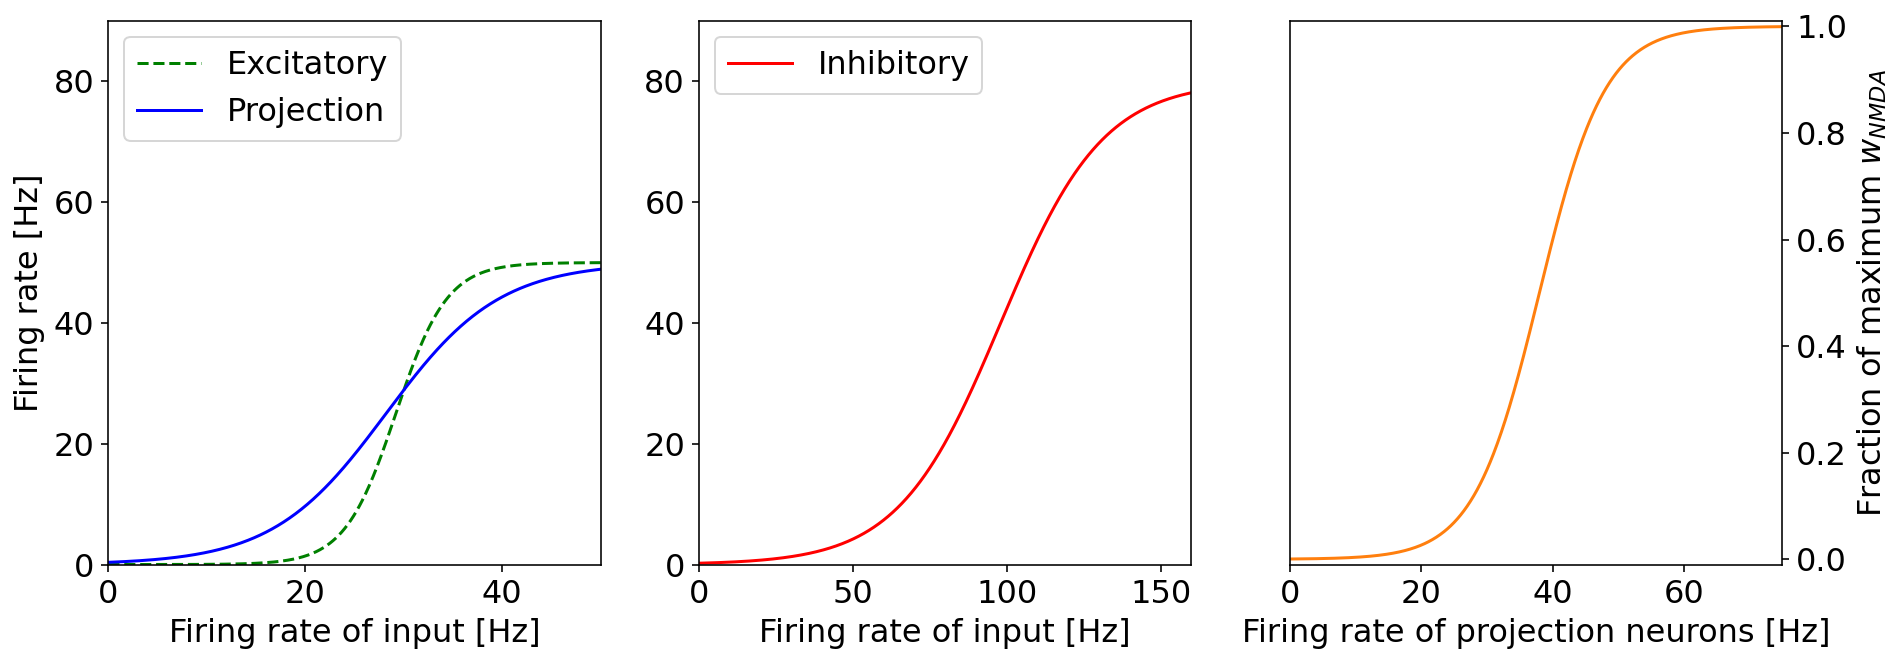

In [2]:
#### Activation functions

pars = default_pars()
x = np.arange(0, 170, .1)

# Compute the activation as function of input firing rate

F_E = F(x, pars['alpha_E'], pars['beta_E'], pars['max_E'])

F_I = F(x, pars['alpha_I'], pars['beta_I'], pars['max_I'])

F_P = F(x, pars['alpha_P'], pars['beta_P'], pars['max_P'])

F_NMDA = F(x, pars['alpha_M'], pars['beta_M'], pars['max_M'])


# Plot activation curves
plt.figure(figsize=(15,5))

ax1 = plt.subplot(1,3,1)
ax1.plot(x, F_E, 'g--', label='Excitatory')
ax1.plot(x, F_P, 'b', label='Projection')

ax2 = plt.subplot(1,3,2)
ax2.plot(x, F_I, 'r', label='Inhibitory')

ax3 = plt.subplot(1,3,3)
ax3.plot(x, F_NMDA/pars['max_M'], 'tab:orange', label='NMDA')


# Format plots
ax1.legend(loc='upper left', fontsize = 16)
ax1.set_xlabel('Firing rate of input [Hz]', fontsize = 16)
ax1.set_ylabel('Firing rate [Hz]', fontsize = 16)
ax1.tick_params(labelsize = 16)
ax1.set_xlim(-0.01, 50.)
ax1.set_ylim(-0.01, 90.)

ax2.legend(loc='upper left', fontsize = 16)
ax2.set_xlabel('Firing rate of input [Hz]', fontsize = 16)
ax2.tick_params(labelsize = 16)
ax2.set_xlim(-0.01, 160.)
ax2.set_ylim(-0.01, 90.)

ax3.set_xlabel('Firing rate of projection neurons [Hz]', fontsize = 16)
ax3.set_ylabel('Fraction of maximum $w_{NMDA}$', fontsize = 16)
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.tick_params(labelsize = 16)
ax3.set_xlim(-0.01, 75.)
ax3.set_ylim(-0.01, 1.01)

plt.show()


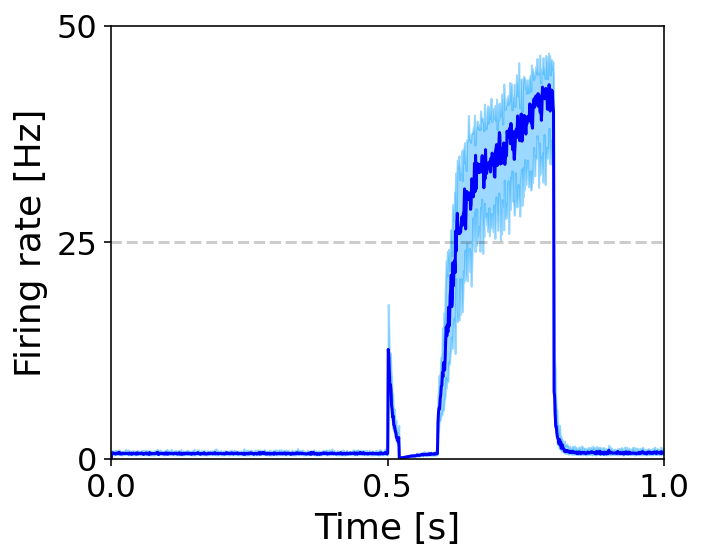

In [3]:
#### Brief noxious stimulation (similar to Crodelle2018 & Crodelle2021)

# Simulation total time, time step and nr iterations
t_tot = 1.
time_step = 0.001
T_sim = int(t_tot/time_step)

# Mean firing rate of afferents [Hz]
baselineRate = 1
stimFreq_innoc = 100
stimFreq_noci = 22
std = 4

# Pattern of mean firing rate of innocuous afferents
# action potentials arrive immediately at t=.5 s
# activity in afferents lasts for .02 s before going back to baseline
innoc_freq = [baselineRate, stimFreq_innoc, baselineRate]
innoc_durs = [.5, .02, t_tot-.5-.02]
innoc_stds = std*np.ones_like(innoc_freq)

# Pattern of mean firing rate of nociceptive afferents
# action potentials arrive after .09 s delay at t=.59 s
# activity in afferents lasts for .21 s before going back to baseline
noci_freq = [baselineRate, stimFreq_noci, baselineRate]
noci_durs = [.59, .21, t_tot-.59-.21]
noci_stds = std*np.ones_like(noci_freq)


# Create random seeds
randomSeeds = range(30)

# initialize list to hold results
all_r_P = np.zeros((len(randomSeeds), int(t_tot/time_step)))

for i, seed in enumerate(randomSeeds):

    # set random seed
    np.random.seed(seed)
    
    # generate firing rate of innocuous and nociceptive afferents
    instFreq_innoc = GenerateNormalInputs(innoc_freq, innoc_stds, innoc_durs, time_step)
    instFreq_noci = GenerateNormalInputs(noci_freq, noci_stds, noci_durs, time_step)

    # initialise simulation parameters
    pars = default_pars(    r_innoc_init=0., r_pain_init=0., r_inhib_init=0.,
                            r_ext_innoc = instFreq_innoc, r_ext_noci = instFreq_noci,
                            T=t_tot, dt=time_step)

    # simulate Wilson-Cowan equations
    r_E, r_P, r_I = simulate_wc_non_neg(**pars)
    
    # store firing rate of projection neurons
    all_r_P[i] = r_P
    

# compute median and quantiles at ±34.1% from the median
median_r_P = np.median(all_r_P, 0)
upper_quantile = np.quantile(all_r_P, .5+.34, axis=0)
lower_quantile = np.quantile(all_r_P, .5-.34, axis=0)

# plot median and quantiles of projection neuron firing rate against time
plt.figure(figsize=(5,4))
ax1 = plt.subplot(111)
ax1.fill_between(pars['range_t'], lower_quantile, upper_quantile, alpha=0.4, edgecolor='#089FFF', facecolor='#089FFF')
ax1.plot(pars['range_t'], median_r_P, 'b', label='Projection neurons')
ax1.plot([-1, t_tot+2], [25, 25], 'k--', alpha = 0.2)

# format plot
ax1.set_ylabel('Firing rate [Hz]', fontsize = 18)
ax1.set_xlabel('Time [s]', fontsize = 18)
ax1.set_xticks([0, 0.5, 1])
ax1.set_yticks([0, 25, 50])
ax1.tick_params(labelsize = 16)
ax1.set_ylim(0,50)
ax1.set_xlim(0,t_tot)

plt.tight_layout()
plt.show()

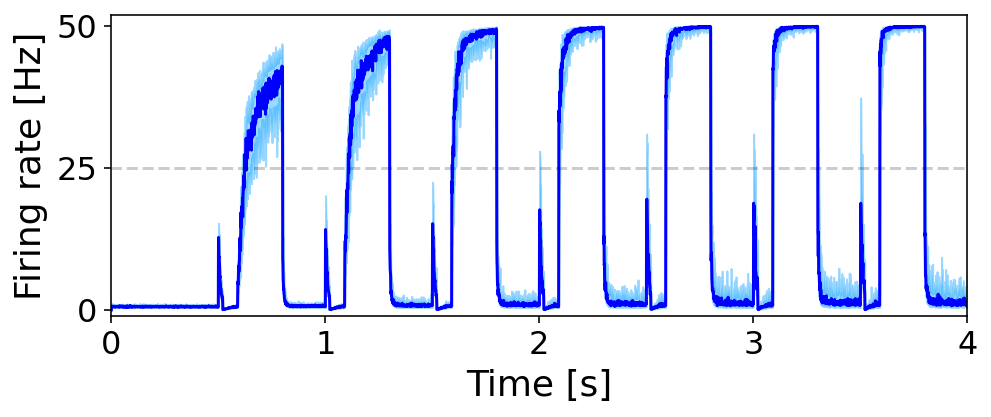

In [5]:
#### Wind up - repeated noxious simulation results in increased response in the projection neurons

# Mean firing rate of afferents [Hz]
baselineRate = 1
stimFreq_innoc = 100
stimFreq_noci = 22
std = 4

# time between stimulations  [s]
windup_interStim = .5

# actual time between arrival of action potentials [s]
# for innocuous afferents, action potentials arrive immediately
# activity in afferents lasts for .02 s before going back to baseline
# -> time between last action potential and first action potential in next stimulation: 
innoc_interStim = windup_interStim - .02

# for nociceptive afferents, action potentials arrive ater .09 s
# activity in afferents lasts for .21 s before going back to baseline
# -> time between last action potential and first action potential in next stimulation: 
noci_interStim = windup_interStim - (.09+.21)

# Pattern of mean firing rate of innocuous afferents
innoc_freq = [baselineRate, stimFreq_innoc, baselineRate,
              stimFreq_innoc, baselineRate, 
              stimFreq_innoc, baselineRate,
              stimFreq_innoc, baselineRate, 
              stimFreq_innoc, baselineRate,  
              stimFreq_innoc, baselineRate,  
              stimFreq_innoc, baselineRate,  baselineRate]
innoc_durs = [.5,  .02, innoc_interStim,
                   .02, innoc_interStim,
                   .02, innoc_interStim,
                   .02, innoc_interStim,
                   .02, innoc_interStim,
                   .02, innoc_interStim,
                   .02, innoc_interStim, .5]
innoc_stds = std*np.ones_like(innoc_freq)

# Pattern of mean firing rate of nociceptive afferents
noci_freq = [baselineRate, stimFreq_noci, baselineRate,
            baselineRate, stimFreq_noci, baselineRate,
            baselineRate, stimFreq_noci, baselineRate,
            baselineRate, stimFreq_noci, baselineRate,
            baselineRate, stimFreq_noci, baselineRate,
            baselineRate, stimFreq_noci, baselineRate,
            baselineRate, stimFreq_noci, baselineRate, baselineRate,]
noci_durs = [.5 + .09, .21, noci_interStim,
                  .09, .21, noci_interStim,
                  .09, .21, noci_interStim,
                  .09, .21, noci_interStim,
                  .09, .21, noci_interStim,
                  .09, .21, noci_interStim,
                  .09, .21, noci_interStim, .5]
noci_stds = std*np.ones_like(noci_freq)

# Simulation total time, time step and nr iterations
t_tot = sum(noci_durs)
time_step = 0.001
T_sim = int(t_tot/time_step)

# Create random seeds
randomSeeds = range(30)

# initialize list to hold results
all_r_P = np.zeros((len(randomSeeds), int(t_tot/time_step)))


for i, seed in enumerate(randomSeeds):
    
    # set random seed
    np.random.seed(seed)
    
    # generate instantaneous firing rate of innocuous and nociceptive afferents
    smooth_instFreq_innoc = GenerateNormalInputs(innoc_freq, innoc_stds, innoc_durs, time_step)
    smooth_instFreq_noci = GenerateNormalInputs(noci_freq, noci_stds, noci_durs, time_step)

    # initialise simulation parameters
    pars = default_pars(    r_innoc_init=0., r_pain_init=0., r_inhib_init=0.,
                            r_ext_innoc = smooth_instFreq_innoc, r_ext_noci = smooth_instFreq_noci,
                            T=t_tot, dt=time_step)

    # simulate Wilson-Cowan equations
    r_E, r_P, r_I = simulate_wc_non_neg(**pars)
    
    # store firing rate of projection neurons
    all_r_P[i] = r_P
    
# compute median and quantiles at ±34.1% from the median
median_r_P = np.median(all_r_P, 0)
upper_quantile = np.quantile(all_r_P, .5+.34, axis=0)
lower_quantile = np.quantile(all_r_P, .5-.34, axis=0)

# plot median and quantiles of projection neuron firing rate against time
plt.figure(figsize=(7,3))
ax1 = plt.subplot(111)
ax1.fill_between(pars['range_t'], lower_quantile, upper_quantile, alpha=0.4, edgecolor='#089FFF', facecolor='#089FFF')
ax1.plot(pars['range_t'], median_r_P, 'b', label='Projection neurons')
ax1.plot([-1, 5], [25, 25], 'k--', alpha = 0.2)

# format plot
ax1.set_ylabel('Firing rate [Hz]', fontsize=18)
ax1.set_xlabel('Time [s]', fontsize=18)
ax1.tick_params(labelsize = 16)
ax1.set_xticks([0, 1, 2, 3, 4])
ax1.set_yticks([0, 25, 50])
ax1.set_ylim(-1,52)
ax1.set_xlim(0.,4.)

plt.tight_layout()
plt.show()

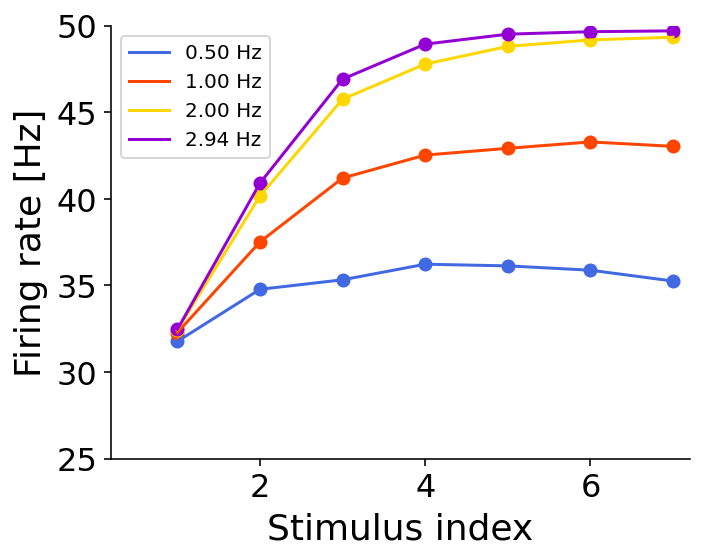

In [4]:
#### Wind up - repeated noxious simulation results in increased response in the projection neurons
##   Here with varying time between stimulations

# Mean firing rate of afferents [Hz]
baselineRate = 1
stimFreq_innoc = 100
stimFreq_noci = 22
std = 4

# inter-stimulation intervals, time between stimulations [s]
windup_interStims = [2., 1., 0.5, 0.34]

# intiate list to store mean firing rate in projection neurons following each stimuli
firingRates = np.zeros((len(windup_interStims), 7))

for w, interStim in enumerate(windup_interStims):
    
    # actual time between arrival of action potentials 
    # for innocuous afferents, action potentials arrive immediately
    # activity in afferents lasts for .02 s before going back to baseline
    # -> time between last action potential and first action potential in next stimulation: 
    innoc_interStim = interStim - .02
    
    # for nociceptive afferents, action potentials arrive ater .09 s
    # activity in afferents lasts for .21 s before going back to baseline
    # -> time between last action potential and first action potential in next stimulation: 
    noci_interStim = interStim - (.09+.21)

    # Pattern of mean firing rate of innocuous afferents
    innoc_freq = [baselineRate, stimFreq_innoc, baselineRate,
                  stimFreq_innoc, baselineRate, 
                  stimFreq_innoc, baselineRate,
                  stimFreq_innoc, baselineRate, 
                  stimFreq_innoc, baselineRate,  
                  stimFreq_innoc, baselineRate,  
                  stimFreq_innoc, baselineRate,  baselineRate]
    innoc_durs = [.5,  .02, innoc_interStim,
                       .02, innoc_interStim,
                       .02, innoc_interStim,
                       .02, innoc_interStim,
                       .02, innoc_interStim,
                       .02, innoc_interStim,
                       .02, innoc_interStim, .5]
    innoc_stds = std*np.ones_like(innoc_freq)

    noci_freq = [baselineRate, stimFreq_noci, baselineRate,
                baselineRate, stimFreq_noci, baselineRate,
                baselineRate, stimFreq_noci, baselineRate,
                baselineRate, stimFreq_noci, baselineRate,
                baselineRate, stimFreq_noci, baselineRate,
                baselineRate, stimFreq_noci, baselineRate,
                baselineRate, stimFreq_noci, baselineRate, baselineRate,]
    noci_durs = [.5 + .09, .21, noci_interStim,
                      .09, .21, noci_interStim,
                      .09, .21, noci_interStim,
                      .09, .21, noci_interStim,
                      .09, .21, noci_interStim,
                      .09, .21, noci_interStim,
                      .09, .21, noci_interStim, .5]
    noci_stds = std*np.ones_like(noci_freq)


    # Simulation total time, time step and nr iterations
    t_tot = sum(noci_durs)
    time_step = 0.001
    T_sim = int(t_tot/time_step)

    # Create random seeds
    randomSeeds = range(30)
    
    # initiate array to store firing rate of projections neurons
    all_r_P = np.zeros((len(randomSeeds), int(t_tot/time_step)))

    for i, seed in enumerate(randomSeeds):

        # set random seed
        np.random.seed(seed)
        
        # generate instantaneous firing rate of innocuous and nociceptive afferents
        instFreq_innoc = GenerateNormalInputs(innoc_freq, innoc_stds, innoc_durs, time_step)
        instFreq_noci = GenerateNormalInputs(noci_freq, noci_stds, noci_durs, time_step)
        
        # initialise simulation parameters
        pars = default_pars(    r_innoc_init=0., r_pain_init=0., r_inhib_init=0.,
                                r_ext_innoc = instFreq_innoc, r_ext_noci = instFreq_noci,
                                T=t_tot, dt=time_step)

        # simulate Wilson-Cowan equations
        r_E, r_P, r_I = simulate_wc_non_neg(**pars)

        # store firing rate of projection neurons
        all_r_P[i] = r_P

    # compute median
    median_r_P = np.median(all_r_P, 0)

    i0 = int((.5 + .09)/time_step)  # arrival of first action potential in nociceptive afferents, first stimulation
    stim_index = int(.21/time_step) # nr time steps during which nociceptive afferents are active at each stimulation
    interStim_index = int((noci_interStim+.09)/time_step)  # nr time steps between arrival of last action potential and first action potential of next stimulations

    # compute mean firing rate in response to each stimuli
    for k in range(7):
        i1 = i0 + k*(stim_index + interStim_index)
        i2 = i1 + stim_index
        firingRates[w][k] = np.mean(median_r_P[i1:i2])


# plot mean firing rate in response to each stimulation for different inter-stimulation intervals        
plt.figure(figsize=(5,4))
ax1 = plt.subplot(111)
si = np.arange(7)

plot_colors = ['royalblue', 'orangered', 'gold', 'darkviolet']
for i, interStim in enumerate(windup_interStims):
    freq = 1/interStim
    lbl = "%1.2f Hz" %freq
    ax1.scatter(si + 1, firingRates[i], color=plot_colors[i])
    ax1.plot(si + 1, firingRates[i], color=plot_colors[i], label=lbl)


# Format plot 
ax1.set_ylabel('Firing rate [Hz]', fontsize=18)
ax1.set_xlabel('Stimulus index', fontsize=18)
ax1.tick_params(labelsize = 16)
ax1.spines[['right', 'top']].set_visible(False)
ax1.set_ylim(25,50)
ax1.set_xlim(.2,7.2)
ax1.legend(loc='upper left')

plt.tight_layout()
plt.show()

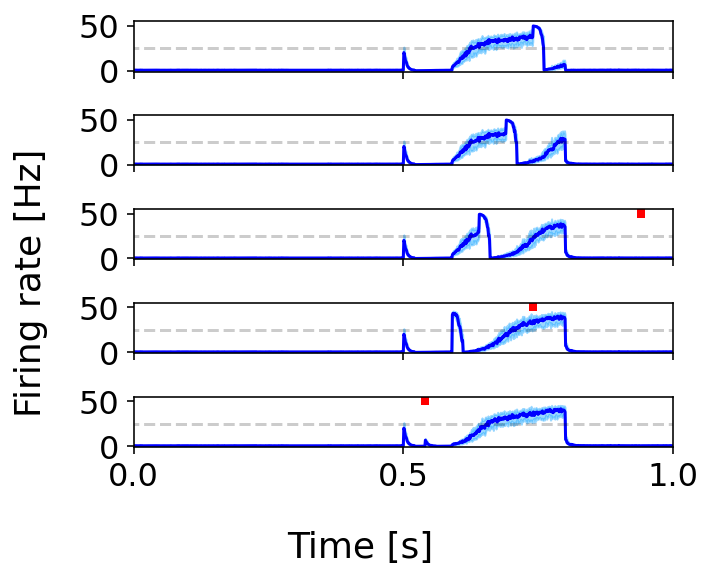

In [6]:
#### Gate control theory - inhibition of pain by innocuous touch

# Mean firing rate of afferents [Hz]
baselineRate = 1
stimFreq_innoc1 = 120
stimFreq_innoc2 = 120
stimFreq_noci = 22
std = 4

# Simulation total time, time step and nr iterations
t_tot = .59+.21+.2
time_step = 0.001
T_sim = int(t_tot/time_step)

n_runs = 5  # number of distinct simulations

# intiate lists to hold results
all_median_r_P = np.zeros((n_runs, T_sim))
upper_quantile = np.zeros((n_runs, T_sim))
lower_quantile = np.zeros((n_runs, T_sim))

# Create random seeds
n_randomSeeds = 30
randomSeeds = range(n_randomSeeds)

for k in range(n_runs):
    
    # time between noxious and innocuous stimulation
    interStim_innoc = k*0.05
    
    # Pattern of mean firing rate of innocuous afferents
    innoc_freq = [baselineRate, stimFreq_innoc1, baselineRate, stimFreq_innoc2, baselineRate]
    innoc_durs = [.5,  .02, 0.02 + interStim_innoc, 0.02, .5-(.02*3 + interStim_innoc)]
    innoc_stds = std*np.ones_like(innoc_freq)

    # Pattern of mean firing rate of nociceptive afferents
    noci_freq = [baselineRate, stimFreq_noci, baselineRate]
    noci_durs = [.59, .21, .2]
    noci_stds = std*np.ones_like(noci_freq)

    # initiate array to store firing rate of projections neurons
    all_r_P = np.zeros((n_randomSeeds, T_sim))
    for i, seed in enumerate(randomSeeds):

        # set random seed
        np.random.seed(seed)
        
        # generate instantaneous firing rate of innocuous and nociceptive afferents
        instFreq_innoc = GenerateNormalInputs(innoc_freq, innoc_stds, innoc_durs, time_step)
        instFreq_noci = GenerateNormalInputs(noci_freq, noci_stds, noci_durs, time_step)
    
        # Initialize simulation parameters
        pars = default_pars(    r_innoc_init=0., r_pain_init=0., r_inhib_init=0.,
                                r_ext_innoc = instFreq_innoc, r_ext_noci = instFreq_noci,
                                T=t_tot, dt=time_step)

        # Simulate Wilson-Cowan equations
        r_E, r_P, r_I = simulate_wc_non_neg(**pars)
    
        # store firing rate of projection neurons
        all_r_P[i] = r_P
    
    # compute and store median and quantiles at ±34.1% from the median
    all_median_r_P[k] = np.median(all_r_P, 0)
    upper_quantile[k] = np.quantile(all_r_P, .5+.34, axis=0)
    lower_quantile[k] = np.quantile(all_r_P, .5-.34, axis=0)
    
# initiate figure with subplots    
fig, ax = plt.subplots(n_runs, 1, sharex=True, sharey=True, figsize=(5,4))

# plot median and quantiles for each distinct simulations
for k in range(n_runs):
    ax[k].plot(pars['range_t'], all_median_r_P[n_runs-k-1], 'b')
    ax[k].fill_between(pars['range_t'], lower_quantile[n_runs-k-1], upper_quantile[n_runs-k-1], alpha=0.4, edgecolor='#089FFF', facecolor='#089FFF')
    ax[k].set_ylim(-1,55)
    ax[k].set_xlim(0.,1.)
    ax[k].plot([-.1, 1.1], [25, 25], 'k--', alpha = 0.2)
    t_stim = .54 + (n_runs-k-1)*interStim_innoc
    ax[k].plot([t_stim, t_stim], [55., 50.], 'r', linewidth=4)
    ax[k].tick_params(labelsize = 16)
    ax[k].set_xticks([0, 0.5, 1])
    ax[k].set_yticks([0, 50])

fig.supylabel('Firing rate [Hz]', fontsize=18)
fig.supxlabel('Time [s]', fontsize=18)

plt.tight_layout()
plt.show()

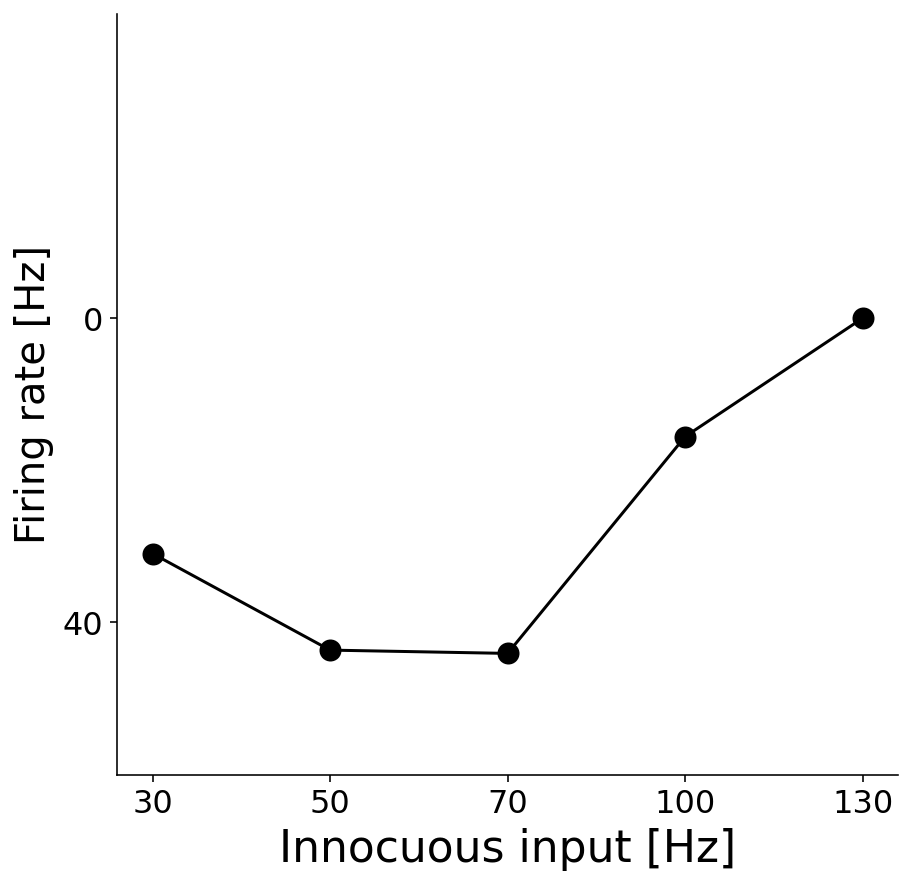

In [7]:
#### Allodynia - innocuous stimulation is perceived as painful
### Altered connection w_ext_innoc_E and w_E_E in the model 
### (Peirs et al., 2015; Smith et al., 2019; Warwick et al., 2022)

# Simulation total time, time step and nr iterations
t_tot = 22
time_step = 0.001
T_sim = int(t_tot/time_step)

# Time within which to measure firing rate
t1 = int(1.1/time_step)
t2 = int((t_tot-1.1)/time_step)

# Slightly elevated baseline firing rate in nociceptive afferents to reflect 
# spontaneous activity of singly firing neurons in neuropathic conditions (Zheng et al., 2022)
baselineRate = 4
std = 4
noci_freq = [baselineRate]
noci_durs = [t_tot]
noci_stds = [std]

# Firing frequency in innocuous afferents to approximately match experiment by (Löken et al., 2017)
stimFreqs = [30., 50., 70., 100., 130.]


median_r_P = np.zeros(len(stimFreqs))
upper_quantile = np.zeros(len(stimFreqs))
lower_quantile = np.zeros(len(stimFreqs))

for i, stimFreq in enumerate(stimFreqs):

    # Pattern of mean firing rate for innocuous afferents
    innoc_freq = [baselineRate, stimFreq, baselineRate]
    innoc_durs = [1.,  20., 1.]
    innoc_stds = std*np.ones_like(innoc_freq)

    # Create random seeds
    randomSeeds = range(30)
    
    # List to store results
    all_r_P = np.zeros(len(randomSeeds))

    for k, seed in enumerate(randomSeeds):

        # generate instantaneous firing rate of innocuous and nociceptive afferents 
        instFreq_innoc = GenerateNormalInputs(innoc_freq, innoc_stds, innoc_durs, time_step)
        instFreq_noci = GenerateNormalInputs(noci_freq, noci_stds, noci_durs, time_step)

        # Initialize simulation parameters, set updated values of w_ext_innoc_E and w_E_E
        pars = default_pars(    r_innoc_init=0., r_pain_init=0., r_inhib_init=0.,
                                r_ext_innoc = instFreq_innoc, r_ext_noci = instFreq_noci,
                                T=t_tot, dt=time_step,
                                w_ext_innoc_E = 0.4, w_E_E = 0.7)

        # Simulate Wilson-Cowan equations
        r_E, r_P, r_I = simulate_wc_non_neg(**pars)

        # store firing rate of projection neurons
        all_r_P[k] = np.mean(r_P[t1:t2])

    # compute and store median and quantiles at ±34.1% from the median
    median_r_P[i] = np.median(all_r_P)
    upper_quantile[i] = np.quantile(all_r_P, .5+.34)
    lower_quantile[i] = np.quantile(all_r_P, .5-.34)


# Plot results
plt.figure(figsize=(7,7))
ax1 = plt.subplot(111)

ax1.plot(range(len(stimFreqs)), -median_r_P, marker = 'o', color = 'k', markersize=10, label='Pleasant/unpleasantness')

# Format plot
ax1.set_ylabel('Firing rate [Hz]', fontsize=20)
ax1.set_yticks([0, -40])
ax1.set_yticklabels([0, 40])
ax1.set_ylim(-60, 40)
ax1.set_xlabel('Innocuous input [Hz]', fontsize=22)
ax1.set_xticks(range(len(stimFreqs)))
ax1.set_xticklabels([int(f) for f in stimFreqs])
ax1.tick_params(labelsize = 16)
ax1.spines[['right', 'top']].set_visible(False)

plt.show()

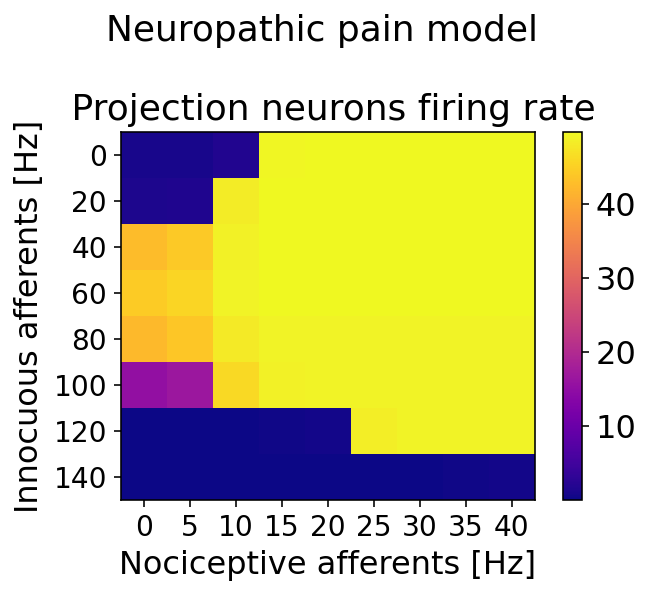

In [8]:
#### Neuropathic pain following nerve injury 
###  -> increased baseline rate due to singly firing neurons in DRG (Zheng et al., 2022)
###  -> cluster firing in DRG, lasts multiple tens of seconds (Zheng et al., 2022)
###  -> altered connection w_ext_innoc_E and w_E_E (Peirs et al., 2015; Smith et al., 2019; Warwick et al., 2022)

# Simulation total time, time step and nr iterations
t_tot = 42
time_step = 0.001
T_sim = int(t_tot/time_step)

# Time within which to measure firing rate
t1 = int(1.1/time_step)
t2 = T_sim

# Slightly elevated baseline firing rate in afferents to reflect 
# spontaneous activity of singly firing neurons in neuropathic conditions (Zheng et al., 2022)
baselineRate = 4
std = 4

# Duration of cluster firing
cluster_dur = 40

# Different levels of activity in nociceptive and innocuous afferents during cluster
freqs_noci = [0, 5, 10, 15, 20, 25, 30, 35, 40]
freqs_innoc = [0, 20, 40, 60, 80, 100, 120, 140]

# List to store results
median_r_Ps_NeP = np.zeros((len(freqs_innoc),len(freqs_noci)))

# Create random seeds
n_randomSeeds = 30
randomSeeds = range(n_randomSeeds)

for i, freq_innoc in enumerate(freqs_innoc):
    
    # Pattern of mean firing rate for innocuous afferents
    if freq_innoc==0:
        freq_innoc += baselineRate
    innoc_freq = [baselineRate, freq_innoc, baselineRate]
    innoc_durs = [1., cluster_dur, t_tot-cluster_dur-1.]
    innoc_stds = std*np.ones_like(innoc_durs)


    
    for n, freq_noci in enumerate(freqs_noci):
        
        # Pattern of mean firing rate for nociceptive afferents
        if freq_noci==0:
            freq_noci += baselineRate
        noci_freq = [baselineRate, freq_noci, baselineRate]
        noci_durs = [1., cluster_dur, t_tot-cluster_dur-1.]
        noci_stds = std*np.ones_like(noci_durs)
    
        # List to store firing rate of projections neurons
        all_r_P = np.zeros(len(randomSeeds))

        for k, seed in enumerate(randomSeeds):

            # generate instantaneous firing rate of innocuous and nociceptive afferents 
            instFreq_innoc = GenerateNormalInputs(innoc_freq, innoc_stds, innoc_durs, time_step)
            instFreq_noci = GenerateNormalInputs(noci_freq, noci_stds, noci_durs, time_step)

            # Initialize simulation parameters, set updated values of w_ext_innoc_E and w_E_E
            pars = default_pars(    r_innoc_init=0., r_pain_init=0., r_inhib_init=0.,
                                    r_ext_innoc = instFreq_innoc, r_ext_noci = instFreq_noci,
                                    T=t_tot, dt=time_step,
                                    w_ext_innoc_E = 0.4, w_E_E = 0.7 )

            # Simulate Wilson-Cowan equations
            r_E, r_P, r_I = simulate_wc_non_neg(**pars)

            # store firing rate of projection neurons
            all_r_P[k] = np.mean(r_P[t1:t2])


        # compute and store median of projection neuron firing rate across trials
        median_r_Ps_NeP[i,n] = np.median(all_r_P)

# Plot results        
fig, ax = plt.subplots(1,1, figsize=(5,4)) 
        
im = ax.imshow( median_r_Ps_NeP , cmap="plasma")
cb = fig.colorbar(im, ax=ax)

# Format plot
cb.ax.tick_params(labelsize=16)
ax.tick_params(labelsize = 14)
ax.set_yticks(range(len(freqs_innoc)))
ax.set_yticklabels([str(x) for x in freqs_innoc])
ax.set_xticks(range(len(freqs_noci)))
ax.set_xticklabels([str(x) for x in freqs_noci])
ax.set_ylabel("Innocuous afferents [Hz]", fontsize = 16)
ax.set_xlabel("Nociceptive afferents [Hz]", fontsize = 16)
ax.set_title("Neuropathic pain model \n\n Projection neurons firing rate", fontsize = 18)

plt.tight_layout()
plt.show()

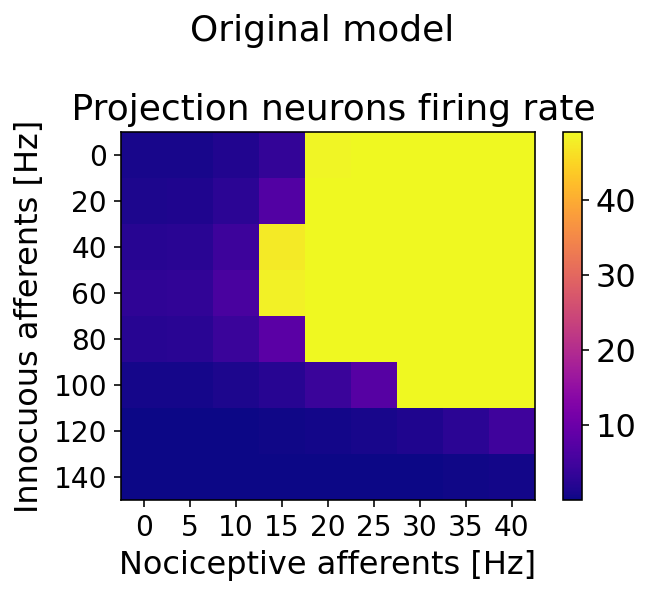

In [31]:
#### Same as bove but with unchanged w_ext_innoc_E and w_E_E 

# Simulation total time, time step and nr iterations
t_tot = 42
time_step = 0.001
T_sim = int(t_tot/time_step)

# Time within which to measure firing rate
t1 = int(1.1/time_step)
t2 = T_sim

# Slightly elevated baseline firing rate in afferents to reflect 
# spontaneous activity of singly firing neurons in neuropathic conditions (Zheng et al., 2022)
baselineRate = 4
std = 4

# Duration of cluster firing
cluster_dur = 40

# Different levels of activity in nociceptive and innocuous afferents during cluster
freqs_noci = [0, 5, 10, 15, 20, 25, 30, 35, 40]
freqs_innoc = [0, 20, 40, 60, 80, 100, 120, 140]

# List to store results
median_r_Ps_NeP = np.zeros((len(freqs_innoc),len(freqs_noci)))

# Create random seeds
n_randomSeeds = 30
randomSeeds = range(n_randomSeeds)

for i, freq_innoc in enumerate(freqs_innoc):
    
    # Pattern of mean firing rate for innocuous afferents
    if freq_innoc==0:
        freq_innoc += baselineRate
    innoc_freq = [baselineRate, freq_innoc, baselineRate]
    innoc_durs = [1., cluster_dur, t_tot-cluster_dur-1.]
    innoc_stds = std*np.ones_like(innoc_durs)


    
    for n, freq_noci in enumerate(freqs_noci):
        
        # Pattern of mean firing rate for nociceptive afferents
        if freq_noci==0:
            freq_noci += baselineRate
        noci_freq = [baselineRate, freq_noci, baselineRate]
        noci_durs = [1., cluster_dur, t_tot-cluster_dur-1.]
        noci_stds = std*np.ones_like(noci_durs)
    
        # List to store firing rate of projections neurons
        all_r_P = np.zeros(len(randomSeeds))

        for k, seed in enumerate(randomSeeds):

            # generate instantaneous firing rate of innocuous and nociceptive afferents 
            instFreq_innoc = GenerateNormalInputs(innoc_freq, innoc_stds, innoc_durs, time_step)
            instFreq_noci = GenerateNormalInputs(noci_freq, noci_stds, noci_durs, time_step)

            # Initialize simulation parameters, set updated values of w_ext_innoc_E and w_E_E
            pars = default_pars(    r_innoc_init=0., r_pain_init=0., r_inhib_init=0.,
                                    r_ext_innoc = instFreq_innoc, r_ext_noci = instFreq_noci,
                                    T=t_tot, dt=time_step )

            # Simulate Wilson-Cowan equations
            r_E, r_P, r_I = simulate_wc_non_neg(**pars)

            # store firing rate of projection neurons
            all_r_P[k] = np.mean(r_P[t1:t2])


        # compute and store median of projection neuron firing rate across trials
        median_r_Ps_NeP[i,n] = np.median(all_r_P)

# Plot results        
fig, ax = plt.subplots(1,1, figsize=(5,4)) 
        
im = ax.imshow( median_r_Ps_NeP , cmap="plasma")
cb = fig.colorbar(im, ax=ax)

# Format plot
cb.ax.tick_params(labelsize=16)
ax.tick_params(labelsize = 14)
ax.set_yticks(range(len(freqs_innoc)))
ax.set_yticklabels([str(x) for x in freqs_innoc])
ax.set_xticks(range(len(freqs_noci)))
ax.set_xticklabels([str(x) for x in freqs_noci])
ax.set_ylabel("Innocuous afferents [Hz]", fontsize = 16)
ax.set_xlabel("Nociceptive afferents [Hz]", fontsize = 16)
ax.set_title("Original model \n\n Projection neurons firing rate", fontsize = 18)

plt.tight_layout()
plt.show()

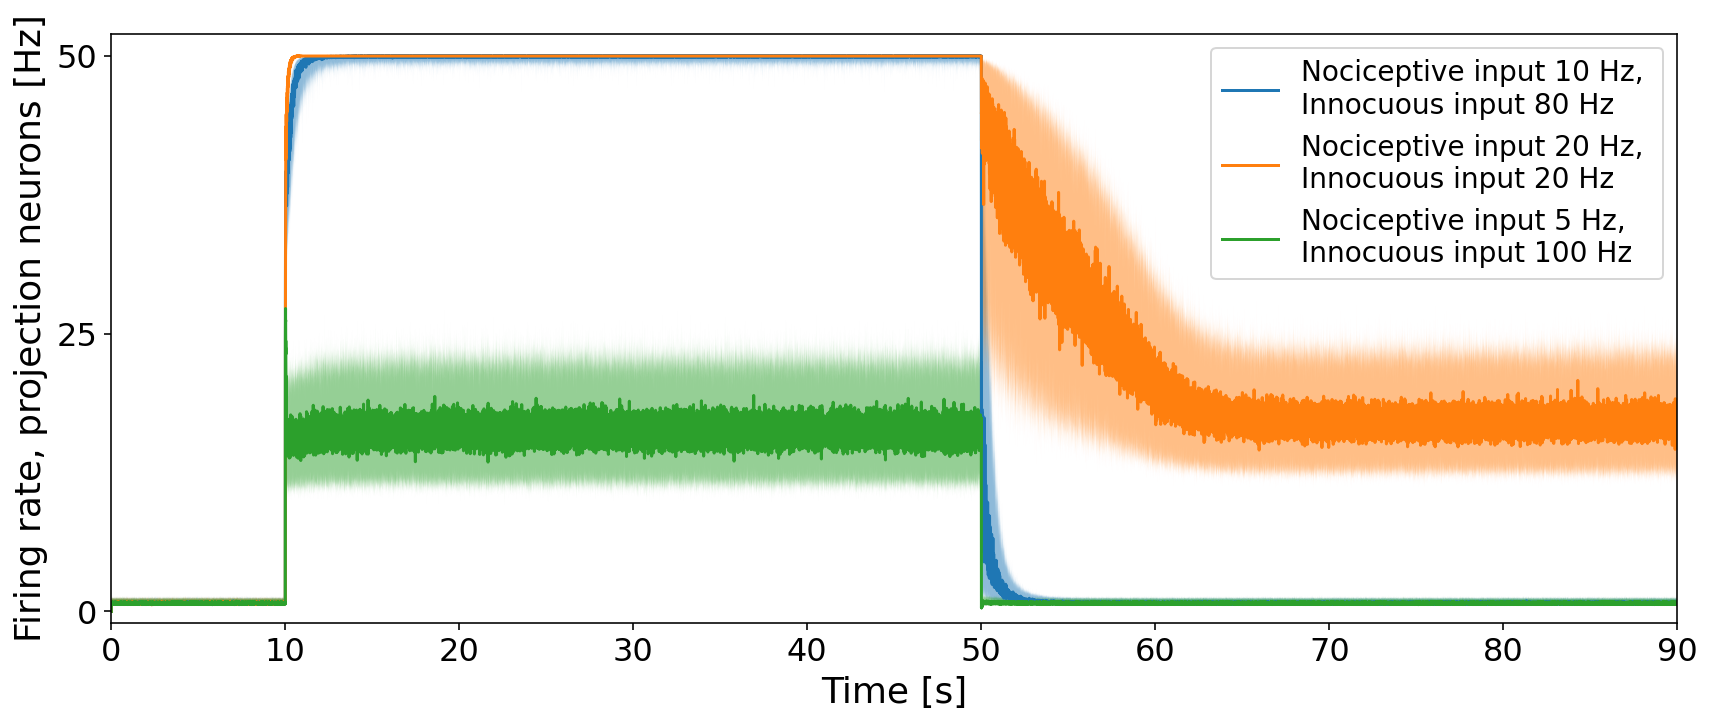

In [54]:
## Example of how projection neuron firing rate may stay elevated even after cluster firing


# Slightly elevated baseline firing rate in afferents to reflect 
# spontaneous activity of singly firing neurons in neuropathic conditions (Zheng et al., 2022)
baselineRate = 4             # increased singly firing spontaneous neurons
std = 4

# Duration of cluster firing and simulation time before cluster
cluster_dur = 40
pre_dur = 10


# Total simulation total time, time step and nr iterations
t_tot = 90
time_step = 0.001
T_sim = int(t_tot/time_step)

# Different levels of activity in nociceptive and innocuous afferents during cluster
freqs_noci = [10, 20, 5]
freqs_innoc = [80, 20, 100]

# intiate lists to hold results
all_median_r_P = np.zeros((len(freqs_noci), T_sim))
upper_quantile = np.zeros((len(freqs_noci), T_sim))
lower_quantile = np.zeros((len(freqs_noci), T_sim))

# Create random seeds
n_randomSeeds = 100
randomSeeds = range(n_randomSeeds)

for i, freq_innoc in enumerate(freqs_innoc):
    
    # Pattern of mean firing rate for innocuous afferents
    if freq_innoc==0:
        freq_innoc += baselineRate
    innoc_freq = [baselineRate, freq_innoc, baselineRate]
    innoc_durs = [pre_dur, cluster_dur, t_tot-cluster_dur-pre_dur]
    innoc_stds = std*np.ones_like(innoc_durs)

    # Pattern of mean firing rate for nociceptive afferents
    freq_noci = freqs_noci[i]
    if freq_noci==0:
        freq_noci += baselineRate
    noci_freq = [baselineRate, freq_noci, baselineRate]
    noci_durs = [pre_dur, cluster_dur, t_tot-cluster_dur-pre_dur]
    noci_stds = std*np.ones_like(noci_durs)
    
    # List to store firing rate of projection neurons
    all_r_P = np.zeros((n_randomSeeds, T_sim))

    for k, seed in enumerate(randomSeeds):

        # generate instantaneous firing rate of innocuous and nociceptive afferents 
        instFreq_innoc = GenerateNormalInputs(innoc_freq, innoc_stds, innoc_durs, time_step)
        instFreq_noci = GenerateNormalInputs(noci_freq, noci_stds, noci_durs, time_step)

        # Initialize simulation parameters, set updated values of w_ext_innoc_E and w_E_E
        pars = default_pars(    r_innoc_init=0., r_pain_init=0., r_inhib_init=0.,
                                r_ext_innoc = instFreq_innoc, r_ext_noci = instFreq_noci,
                                T=t_tot, dt=time_step,
                                w_ext_innoc_E = 0.4, w_E_E = 0.7)

        # Simulate Wilson-Cowan equations
        r_E, r_P, r_I = simulate_wc_non_neg(**pars)

        # store firing rate of projection neurons
        all_r_P[k] = r_P

    # compute and store median and quantiles at ±34.1% from the median
    all_median_r_P[i] = np.median(all_r_P, 0)
    upper_quantile[i] = np.quantile(all_r_P, .5+.34, axis=0)
    lower_quantile[i] = np.quantile(all_r_P, .5-.34, axis=0)


# plot median quantiles of projection neuron firing rate against time
plt.figure(figsize=(12,5))
ax1 = plt.subplot(111)
for i, freq_innoc in enumerate(freqs_innoc):
    freq_noci = freqs_noci[i]
    lbl = "Nociceptive input %.0f Hz, \nInnocuous input %.0f Hz" %(freq_noci, freq_innoc)
    ax1.fill_between(pars['range_t'], lower_quantile[i], upper_quantile[i], alpha=0.5)#, edgecolor='#089FFF', facecolor='#089FFF')
    ax1.plot(pars['range_t'], all_median_r_P[i], label=lbl)


# format plot
ax1.legend(loc='upper right', fontsize = 14)
ax1.set_ylabel('Projection neuron firing rate[Hz]', fontsize=16)
ax1.set_xlabel('Time [s]', fontsize=18)
ax1.tick_params(labelsize = 16)
ax1.set_yticks([0, 25, 50])
ax1.set_ylim(-1,52)
ax1.set_xlim(0.,t_tot)

plt.tight_layout()
plt.show()